### 2. Data Preparation and Analysis
- This is the second notebook which contains componets 2 and 3 of the assignment.

- I will load the saved dataset (raw NBA data) from Part 1 into appropriate data structures, I have chosen to use pandas data frames as the main data structure using dictionaries for intermediary data parsing steps.

- I will apply any data preprocessing steps that might be required to clean, filter or transform the dataset before analysis.

- I will Analyse, characterise, and summarise the cleaned dataset, using tables and visualisations where appropriate.

- I would like to find what features that indicate better player productivity offensively and defensively as well as detractors.

- Then I would like to find a way to visualise the top players and their stats for making an overall strongly positive contribution to their respective teams, excluding players that fail in key defensive/offensive areas (turnovers, fouls, points, blocks, steals and assists) or overall productivity features like (plusMinus score, minutes played etc).

- Load packages and libraries

In [1]:
import http.client
import json
from pathlib import Path
import pandas as pd
from scipy.stats import shapiro

from datetime import datetime, date

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.io as pio

from IPython.display import HTML, Javascript, display

pip install plotly 
pip install cufflinks 
pip install chart_studio

import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import init_notebook_mode

- Basic notebook configurations for rendering plots

In [2]:
# magic function, renders matplotlib figures in notebook / inline
%matplotlib inline 
pd.options.plotting.backend = "plotly"
# pio.renderers.default = 'notebook'
pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=False)
cf.go_offline()

- Set file read configurations

In [3]:
# directory for raw data storage
dir_raw = Path("raw")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

## Data Preprocessing

In [4]:
# init config, runtime variables and counters
teams = ["atlanta hawks", "boston celtics", "brooklyn nets", "charlotte hornets", "chicago bulls", 
         "cleveland cavaliers", "dallas mavericks", "denver nuggets", "detroit pistons", "golden state warriors", 
         "houston rockets", "indiana pacers", "la clippers", "los angeles lakers", "memphis grizzlies", "miami heat", 
         "milwaukee bucks", "minnesota timberwolves", "new orleans pelicans", "new york knicks", "oklahoma city thunder",
         "orlando magic", "philadelphia 76ers", "phoenix suns", "portland trail blazers", "sacramento kings", 
         "san antonio spurs", "toronto raptors", "utah jazz", "washington wizards"]
seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

player_files = {}
for team_name in teams:
    player_files[team_name] = []
    
stats_files = {}
for team_name in teams:
    for season in seasons:
        stats_files[team_name + ' ' + str(season)] = []

stats_rec_cnt = 0
player_indiv_cnt = 0

debug_mode = False

In [5]:
# iterate through raw data on disk
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        fin = open(fpath, "r")
        jdata = fin.read()
        data = json.loads(jdata)
        
        # parse the filename
        parts = fpath.stem.split("_")
        
        # set season, team and file type
        team = ''
        season = ''
        data_type = parts[-1]
        if (len(parts) >= 5 and len(parts[3]) == 4):
            team = parts[0] + ' ' + parts[1] + ' ' + parts[2]
            season = parts[3]
        else:
            team = parts[0] + ' ' + parts[1]
            season = parts[2]
        
        # add data to dict before merging
        if (team in teams):
            number_records = len(data['response'])
            if debug_mode:
                print("Reading data for the %s for season %s with data type %s with %s records" % (team, season, data_type, number_records))
            if (data_type == 'players'):   
                player_files[team] = pd.DataFrame.from_dict(data["response"])
                player_indiv_cnt += number_records
            elif (data_type == 'stats'):
                stats_files[team + ' ' + str(season)] = pd.DataFrame.from_dict(data["response"])
                stats_rec_cnt += number_records
            else:
                print('Invalid data type: ', data_type)
                
print("Finished reading %s player statistics records" % (stats_rec_cnt))
print("Finished reading %s individual player records" % (player_indiv_cnt))
            

Finished reading 309697 player statistics records
Finished reading 7378 individual player records


## Data Parsing and Merging

- Define function to get player age from DOB

In [6]:
# calculate player age from date of birth (DOB)
def get_player_age(birth_date):
    if (birth_date != '' and birth_date is not None):
        dob = datetime.strptime(birth_date, '%Y-%m-%d').date()
        today = date.today()
        return today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    else:
        return None

- Concatenate all data from player statitics files

In [7]:
df_player_stats = pd.concat(stats_files)

- Concatenate all data from individual player files

In [8]:
df_player_details = pd.concat(player_files)

## Data Verification
- Assert number of records loaded is as expected

In [9]:
print(df_player_stats.shape)
# 309697 (18553 for 6x teams 21-23) is total number of player stats records
df_player_stats.shape[0] == 309697

(309697, 25)


True

In [10]:
print(df_player_details.shape)
df_player_details.shape[0] == 716

(716, 10)


True

- 716 still high (possible dupes) as there are 450 ish players in the NBA per season
- Player details data in parts is duplicated from season to season so have kept the main information

- Normalise nested JSON fields and extract the features needed for merging and analysis
- Drop duplicate data and nested JSON fields when ready

In [11]:
# Normalize nested JSON objects for player game statistics
df_player = pd.json_normalize(df_player_stats['player'])# pull player_id and merge first/last name for player_name
df_team = pd.json_normalize(df_player_stats['team']) # pull team_id, team_code and name (drop team name index)
df_game = pd.json_normalize(df_player_stats['game']) # Extract game ID

# Normalize nested JSON objects for player details
df_birth = pd.json_normalize(df_player_details['birth'])# pull country and DOB
df_height = pd.json_normalize(df_player_details['height'])# pull height in mteres and merge feets/inches into ft_height
df_leagues = pd.json_normalize(df_player_details['leagues'])# pull standard.active	standard.jersey	standard.pos
df_nba = pd.json_normalize(df_player_details['nba'])# pull pro and start for international player insights ?
df_weight = pd.json_normalize(df_player_details['weight'])# pull kilograms and pounds

In [12]:
# Extract normalized data to player stats DF
df_player_stats = df_player_stats.reset_index(drop=False)

del df_player_stats['level_1']
df_player_stats['season'] = df_player_stats['level_0'].apply(lambda x: x.split(' ')[-1])
del df_player_stats['level_0']

df_player_stats['player_id'] = df_player['id']
df_player_stats['player_name'] = df_player['firstname'] + ' ' + df_player['lastname']

del df_player_stats['player']

df_player_stats['team_code'] = df_team['code']
df_player_stats['team_name'] = df_team['name']
df_player_stats['team_id'] = df_team['id']

del df_player_stats['team']

df_player_stats['game_id'] = df_game['id']

del df_player_stats['game']

df_player_stats['min'] = pd.to_numeric(df_player_stats['min'], errors='coerce')
df_player_stats['plusMinus'] = pd.to_numeric(df_player_stats['plusMinus'], errors='coerce')

In [13]:
# Extract normalized data to player details DF
df_player_details = df_player_details.reset_index(drop=True)

df_player_details['country'] = df_birth['country']
df_player_details['DOB'] = df_birth['date']

df_player_details['age'] = df_player_details['DOB'].apply(get_player_age)
df_player_details['age'] = df_player_details['age'].fillna(0).astype('int')
del df_player_details['birth']

df_player_details['feet'] = df_height['feets'] + '\"' + df_height['inches']
df_player_details['meters'] = df_height['meters']
df_player_details['meters'] = pd.to_numeric(df_player_details['meters'], errors='coerce')
df_player_details['meters'] = df_player_details['meters'].apply(lambda x: round(float(x), 2) if x != None else x)
del df_player_details['height']

df_player_details['position'] = df_leagues['standard.pos']
df_player_details['active'] = df_leagues['standard.active']
df_player_details['jersey_number'] = df_leagues['standard.jersey']
del df_player_details['leagues']

df_player_details['years_pro'] = df_nba['pro']
df_player_details['rookie_year'] = df_nba['start']
del df_player_details['nba']

df_player_details['pounds'] = df_weight['pounds']
df_player_details['pounds'] = df_player_details['pounds'].astype('Int16')
del df_player_details['weight']

In [14]:
df_player_stats.shape # verify record count is the same and new column count

(309697, 29)

### Merge player performance statistics and individual player information

In [15]:
# merge data frames (player game statistics and player details)
df = pd.merge(df_player_stats, df_player_details, how='left', left_on='player_id', right_on='id')

- View features available for analysis

In [16]:
df.columns

Index(['assists', 'blocks', 'comment', 'defReb', 'fga', 'fgm', 'fgp', 'fta',
       'ftm', 'ftp', 'min', 'offReb', 'pFouls', 'plusMinus', 'points', 'pos',
       'steals', 'totReb', 'tpa', 'tpm', 'tpp', 'turnovers', 'season',
       'player_id', 'player_name', 'team_code', 'team_name', 'team_id',
       'game_id', 'affiliation', 'college', 'firstname', 'id', 'lastname',
       'country', 'DOB', 'age', 'feet', 'meters', 'position', 'active',
       'jersey_number', 'years_pro', 'rookie_year', 'pounds'],
      dtype='object')

- Set DataFrame index to season / year

In [17]:
# set season (year) as main DF index to allow for time series analysis of player data
df = df.reset_index().set_index('season')
df.index = pd.to_datetime(df.index, format='%Y').to_period('Y')
df = df.sort_index(axis=0)

## Data Analysis

- Set font size
- Define function to create time series plot
- Define function to summarise top players for a given performance statistic (i.e. Points scored, Blocks, Steals, Rebounds, Field Goal Percentage etc.)
- Define function to highlight cell greater or equal threshold of 0.7 and less than 1

In [18]:
fontsize=22

# convenience function for time series plots
def create_ts_plot(data, title, ylabel, color="navy", rhs_vals=None):
    # create a time series plot
    pd.options.plotting.backend = "matplotlib"
    ax = data.plot(figsize=(9, 4.3), legend=False, lw=2, zorder=3, color=color)
    plt.title(title, fontsize=fontsize-1)
    plt.ylabel(ylabel)
    plt.xlabel(None)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    return ax

# convenience function to aggregate top players by a given statistic or feature
def summary_top_players(grp, stat,  sort_by = 'mean', results = 10):
    df[stat] = pd.to_numeric(df[stat], errors='coerce')# handle nans and plusMinus values which are char in format ''+/-[0-9]*'
    df_aggs = round(df.groupby([grp])[stat].agg(['mean', 'sum']), 2)
    return df_aggs.sort_values(by=sort_by, ascending=False).head(results)

# convenience method to highlight data frame cell lime green
def highlighter(cell_value, thresh_lower = 0.7, thresh_upper = 0.99):
    if cell_value < thresh_upper and cell_value >= thresh_lower:
        return "background-color: #32CD32"
    elif cell_value == 1:
        return "background-color: yellow"

- Convert pounds feature to numeric column and get mean value

In [19]:
df['pounds'] = pd.to_numeric(df['pounds'])
print("Average player weight %s lbs." % round(df['pounds'].mean(skipna = True), 2))

Average player weight 218.43 lbs.


- Convert meters feature to numeric column and get mean value

In [20]:
df['meters'] = pd.to_numeric(df['meters'])
round(df['meters'].mean(skipna = True), 2)
print("Average player height %s meters" % round(df['meters'].mean(skipna = True), 2))

Average player height 1.99 meters


- Check is there a correlation between player weight in lbs and height in meters

In [21]:
df[['pounds', 'meters']].corr()

pounds    meters
pounds  1.000000  0.786799
meters  0.786799  1.000000

- There is a strong correlation between player weight and height
- Taller players are more likely to be heavier, However, there is still room for some outliers to this trend
- Lets visualise this as an interactive scatter plot

In [22]:
df.plot('pounds', 'meters', 'scatter')

- I think this is a good approach to find some important features in this dataset related to player performance
- I am now going to look at the correlation table for all numeric columns
- Then I will apply a cell highlighter for interesting fields in the correlation matrix with a strong relationship or corerelation (over 70%)

In [23]:
numeric_cols = ['assists', 'blocks', 'defReb', 'fga', 'fgm', 'fgp', 'fta', 'ftm', 'ftp', 'offReb', 'pFouls', 
                'points', 'steals', 'totReb', 'tpa', 'tpm', 'tpp', 'turnovers', 'age', 'meters', 'min', 'plusMinus',
                'pounds', 'years_pro', 'rookie_year', 'jersey_number']

df_corr_c = df[numeric_cols].corr()

df_corr_c.style.applymap(highlighter)

- This is still a bit awkward to decode so I am going to list the same info as a list with the feature pairs that have the strongest correlation prioritiesd to the top of the list

In [24]:
df_corr_c = df[numeric_cols].corr().abs().unstack().sort_values(ascending=False)
df_corr_c[(df_corr_c < 1) & (df_corr_c >= 0.7)]# exclude below 74% correlation and 100% for matching cols in corr matrix

points       fgm            0.968162
fgm          points         0.968162
ftm          fta            0.955994
fta          ftm            0.955994
defReb       totReb         0.940153
totReb       defReb         0.940153
fga          points         0.897757
points       fga            0.897757
fgm          fga            0.897693
fga          fgm            0.897693
age          rookie_year    0.846967
rookie_year  age            0.846967
tpm          tpa            0.824443
tpa          tpm            0.824443
fga          min            0.795726
min          fga            0.795726
meters       pounds         0.786799
pounds       meters         0.786799
points       min            0.744453
min          points         0.744453
fgm          min            0.729350
min          fgm            0.729350
fga          tpa            0.714330
tpa          fga            0.714330
ftp          ftm            0.706892
ftm          ftp            0.706892
tpm          tpp            0.703801
t

- We can see 'points' (Points scored) and field goals made ('fgm') have the strongest correlation which is interesting.
- We can see other fields of interest that have a strong correlation with 'points' are 'fga' (Field Golas Attempted), and 'min' (Minutes Played)
- Rebounding related fields have a strong relationship (defensive, offensive and total rebounds) which makes sense
- Weight and Height, Field Goal related, Three Pointer features (tpm, tpa), Free Throws (ftp, fta, ftm), and age / years playing professional all figure as field pairs/tuples that have strong correlation which is expected.
- A player that scores a lot of field goals tend to score more points, more so than a higher scoring rate of free throws or three pointers
- On the other side, if we look back at the correlation matrix: Blocks, Steals and Assists are often stand alone performance statistics that to not seem to have a strong correlation with any other feature
- This is also true for categories that have a negative aspect to player performance such as personal founls (pFouls) and turnovers.
- PlusMinus is a very prominent feature as it measures the positive or negative impact and contribution a player has for his team for a given game while on court, over the course of a season this is a telling statistic.

- I would like to view a time series line plot of the avergae player weight per season

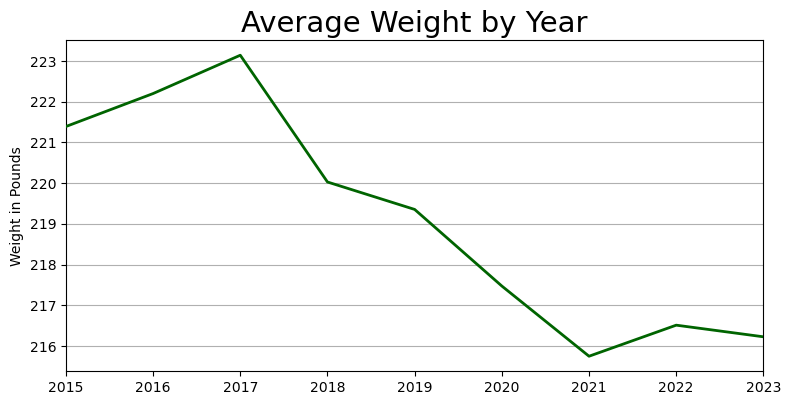

In [25]:
df_weight = df.copy()
df_weight.index = df_weight.index.to_timestamp()

df_weight = df_weight['pounds'].resample("1Y").mean()
create_ts_plot(df_weight, "Average Weight by Year", "Weight in Pounds", "darkgreen");

- From this plot it appears the players are lighter overall since 2015 and trending down in weight by 5/6 lbs from 2015 - 2023
- Lets verify this by checking the mean weight of players per the 2015 season data and again for 2023

In [26]:
avg_weight_2015 = round(df[df.index == '2015']['pounds'].mean(), 2)
print("Average weight for 2015: %s pounds" % avg_weight_2015)

Average weight for 2015: 221.39 pounds


In [27]:
avg_weight_2023 = round(df[df.index == '2023']['pounds'].mean(), 2)
print("Average weight for 2023: %s pounds" % avg_weight_2023)

Average weight for 2023: 216.23 pounds


In [28]:
print("Difference in weight from 2015 to 2023: %s lbs" % (round(avg_weight_2015 - avg_weight_2023, 2)))

Difference in weight from 2015 to 2023: 5.16 lbs


- Heaviest Players in the NBA from 2015-2023

In [29]:
df[['player_name', 'pounds', 'meters', 'feet']].reset_index(drop=True).sort_values(by=['pounds'], ascending=False).drop_duplicates()[0:5]

player_name  pounds  meters  feet
232483      Jusuf Nurkic     290    2.11  6"11
118047  Boban Marjanovic     290    2.21   7"3
127435      Nikola Jokic     284    2.11  6"11
322422   Zion Williamson     284    1.98   6"6
230123       Brook Lopez     282    2.13   7"0

- Notably Zion Williamson is quite heavy for his height (under 2 meters)

- Lighest Players in the NBA from 2015-2023

In [30]:
df[['player_name', 'pounds', 'meters', 'feet']].reset_index(drop=True).sort_values(by=['pounds'], ascending=True).drop_duplicates()[0:5]

player_name  pounds  meters feet
326649  Terquavion Smith     160     NaN  NaN
334980   Markquis Nowell     160     NaN  NaN
247075        DJ Steward     163    1.88  6"2
281893        Trae Young     164    1.85  6"1
210185        Isaiah Joe     165    1.93  6"4

- View average height for players in 2017

In [31]:
print("Average height for players in 2017: %s meters" % round(df[df.index == '2017']['meters'].mean(), 3))

Average height for players in 2017: 2.002 meters


- View average height for players in 2021

In [32]:
print("Average height for players in 2021: %s meters" % round(df[df.index == '2021']['meters'].mean(), 3))

Average height for players in 2021: 1.989 meters


- I would like to view a time series line plot of the avergae player height per season to get a better idea of this data and trend

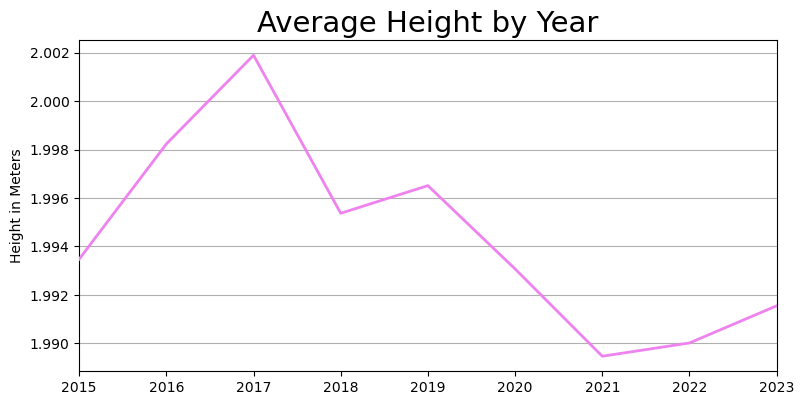

In [33]:
df_height = df.copy()
df_height.index = df_height.index.to_timestamp()

df_height = df_height['meters'].resample("1Y").mean()
create_ts_plot(df_height, "Average Height by Year", 
               "Height in Meters", "violet");

- As opposed to the trend in average player weight (trending down), the average player height has not varied much from 2015 - 2023. 
- The average height staying at 1.99 to 2 meters (6"6 in feet and inches).

- Next, lets get an idea of the distribution of total minutes played by NBA players from 2015-2023 
- I would like to know the if it is a normal distribution and are there any outliers

In [34]:
# create histogram visual
mins_played_summary = summary_top_players('player_name', 'min', results = 800)['sum']
h = mins_played_summary.hist(backend='plotly', labels=dict(index='Player Count', value='Minutes Played', 
                                                           variable='Total Minutes Played'))
h.layout.yaxis.title.text = 'Player Count'
h

- Not a bell shape or the expected normal distribution, we can confirm this with the Shapiro-Wilk test where we can reject the null hypothesis when p value is less than 0.05 and say the data does not come from a normal distribution

In [35]:
test_normality = shapiro(mins_played_summary)

print(test_normality)

ShapiroResult(statistic=0.8247761726379395, pvalue=1.1422826518963018e-28)


In [36]:
is_not_normal_dist = (test_normality.pvalue < 0.05) and (test_normality.statistic > 0.8)
print("Can we reject the null hypothesis and say this is not a normal distribution (bell shaped): %s" % is_not_normal_dist)

Can we reject the null hypothesis and say this is not a normal distribution (bell shaped): True


- We can see most players fall into bins where they have played less than 5k minutes in this time (the majority have less than 500 mins playing time at a count of 340 players) 
- However, the distribution is right skewed distribution with a gap before a group of players that have between 7.5k and 10k approx. playing minutes in that time frame of 9 years, this may be due to playoff runs of teams that have smaller squads or players that seem to avoid injury more often than not.
- Lets view the players in this group, `Note`: It will be interesting if they end up in the group of players with the best team impact.

In [37]:
df_mins = summary_top_players('player_name', 'min', sort_by = 'sum', results = 20)
df_mins[df_mins['sum'] > 7500]
df_mins

mean      sum
player_name                      
Pascal Siakam      34.95  10204.0
Spencer Dinwiddie  31.47   9692.0
RJ Barrett         32.77   9438.0
Dennis Schroder    29.51   9148.0
Bruce Brown        27.79   9116.0
Buddy Hield        28.63   9048.0
Immanuel Quickley  28.26   8818.0
Royce O'Neale      28.51   8666.0
P.J. Washington    31.08   8578.0
Grant Williams     25.74   8390.0
O.G. Anunoby       33.79   8244.0
Terry Rozier       34.19   8206.0
Kyle Lowry         28.26   7688.0
Quentin Grimes     25.65   6978.0
Kelly Olynyk       24.72   6922.0
Shake Milton       17.17   6849.0
Daniel Gafford     22.35   6438.0
Bojan Bogdanovic   30.87   6420.0
Patrick Beverley   23.01   6396.0
Kenyon Martin Jr.  21.84   6072.0

- Pascal Siakam is the only player with more than 10k mins played. He was heavily relied upon especially during torontos championship run in 2019 along with Kyle Lowry.
- This is notable because that was a first NBA championship for Toronto / Canada (help to grow the game beyond the USA).
- Keeping top players injury free was key for them more so than some heavyweight teams like warriors, lakers etc.
- Otherwise, while top players, the players listed here are mostly not huge names come the business end of the season and I do not expect to see these names in the final elite player group for the past 9 years.

- Lets view the top players in different stat groupings by average (mean is default sort order) or total (sum when specified in `sort_by` parameter) where appropriate.

In [38]:
summary_top_players('player_name', 'points', sort_by = 'sum', results=5)

mean      sum
player_name                     
Danilo Gallinari  14.56  22974.0
Bojan Bogdanovic  16.04  22392.0
Kyle Lowry        15.60  21774.0
Pascal Siakam     17.00  21358.0
Dennis Schroder   14.65  21236.0

In [39]:
summary_top_players('player_name', 'points', results=5)

mean      sum
player_name                  
Luka Doncic    28.11  12341.0
Stephen Curry  27.27  18435.0
Kevin Durant   27.17  16409.0
James Harden   26.81  19869.0
Joel Embiid    26.35  13491.0

In [40]:
summary_top_players('player_name', 'assists', sort_by = 'sum', results=5)

mean     sum
player_name                    
Kyle Lowry         6.43  8974.0
Dennis Schroder    4.88  7076.0
James Harden       8.75  6483.0
Russell Westbrook  8.78  6461.0
Spencer Dinwiddie  5.18  5868.0

In [41]:
summary_top_players('player_name', 'assists', results=5)

mean     sum
player_name                    
Trae Young         9.20  4288.0
Russell Westbrook  8.78  6461.0
James Harden       8.75  6483.0
John Wall          8.64  3102.0
Tyrese Haliburton  8.55  2207.0

In [42]:
summary_top_players('player_name', 'fgp', sort_by = 'sum', results=5)

mean      sum
player_name                     
Danilo Gallinari  40.70  64227.6
Mike Muscala      36.17  64124.4
Kelly Olynyk      44.63  63639.2
Thaddeus Young    47.57  62509.8
Bismack Biyombo   46.17  61775.2

In [43]:
summary_top_players('player_name', 'ftp', sort_by = 'sum', results=5)# free throw percentage

mean       sum
player_name                       
Danilo Gallinari   73.84  116524.2
Bojan Bogdanovic   68.30   95348.6
Dennis Schroder    65.62   95155.8
Kyle Lowry         65.66   91666.2
Spencer Dinwiddie  65.51   74161.8

In [44]:
summary_top_players('player_name', 'tpp', sort_by = 'sum', results=6)# three-point percentage

mean      sum
player_name                     
Danilo Gallinari  35.08  55358.1
Buddy Hield       39.16  51850.8
Bojan Bogdanovic  36.20  50529.8
Kyle Lowry        36.01  50270.6
Patty Mills       36.11  49978.2
P.J. Tucker       31.49  47612.0

In [45]:
summary_top_players('player_name', 'offReb', sort_by = 'sum', results=5)# offensive rebounds

mean     sum
player_name                 
Andre Drummond  4.01  2788.0
Steven Adams    3.95  2531.0
Clint Capela    3.61  2510.0
Thaddeus Young  1.89  2486.0
Rudy Gobert     3.39  2441.0

In [46]:
summary_top_players('player_name', 'defReb', sort_by = 'sum', results=5)# defensive rebounds

mean     sum
player_name                        
Giannis Antetokounmpo  8.74  6412.0
Rudy Gobert            8.72  6290.0
Pascal Siakam          4.99  6268.0
Danilo Gallinari       3.94  6225.0
Nikola Jokic           7.93  6128.0

In [47]:
summary_top_players('player_name', 'totReb', results=5)# Total rebounds by average

mean     sum
player_name                         
Andre Drummond         12.30  8564.0
Rudy Gobert            12.11  8731.0
Giannis Antetokounmpo  10.71  7863.0
Joel Embiid            10.70  5480.0
Karl-Anthony Towns     10.62  6678.0

In [48]:
summary_top_players('player_name', 'totReb', sort_by = 'sum', results=5)# Total rebounds by total/sum

mean     sum
player_name                  
Rudy Gobert     12.11  8731.0
Andre Drummond  12.30  8564.0
Nikola Jokic    10.55  8153.0
P.J. Tucker      5.37  8116.0
Pascal Siakam    6.44  8090.0

In [49]:
summary_top_players('player_name', 'blocks', sort_by = 'sum', results=5)# blocked shots

mean     sum
player_name                  
Rudy Gobert      2.07  1495.0
Bismack Biyombo  1.04  1396.0
Myles Turner     2.20  1371.0
Anthony Davis    2.16  1361.0
Brook Lopez      1.87  1319.0

In [50]:
summary_top_players('player_name', 'blocks', results=6)# blocked shots by average

mean     sum
player_name                    
Selom Mawugbe      4.50     9.0
Victor Wembanyama  3.35   211.0
Chet Holmgren      2.45   174.0
Walker Kessler     2.41   332.0
Myles Turner       2.20  1371.0
Anthony Davis      2.16  1361.0

- Notable inclusions here for average blocked shots instead of total/sum blocked shots in 9 years (Highly touted rookies Victor Wenbamyama & Chet Holmgren)

In [51]:
summary_top_players('player_name', 'steals', sort_by = 'sum', results=5)

mean     sum
player_name                   
Robert Covington  1.53  1886.0
Kyle Lowry        1.30  1814.0
Thaddeus Young    1.29  1698.0
P.J. Tucker       1.04  1568.0
Delon Wright      1.14  1326.0

In [52]:
summary_top_players('player_name', 'fgm', sort_by = 'sum', results=5)

mean     sum
player_name                   
Pascal Siakam     6.48  8140.0
Dennis Schroder   5.36  7774.0
Bojan Bogdanovic  5.50  7682.0
Buddy Hield       5.62  7436.0
LeBron James      9.90  7029.0

In [53]:
summary_top_players('player_name', 'fgm', results=6)

mean     sum
player_name                         
DMitrik Trice          10.00    10.0
LeBron James            9.90  7029.0
Luka Doncic             9.58  4205.0
Giannis Antetokounmpo   9.57  7025.0
Kevin Durant            9.54  5763.0
Anthony Davis           9.07  5722.0

In [54]:
summary_top_players('player_name', 'fga', results=5)

mean      sum
player_name                     
Luka Doncic       20.36   8936.0
Donovan Mitchell  19.36  10514.0
Stephen Curry     19.15  12947.0
Damian Lillard    19.02  12803.0
LeBron James      18.93  13442.0

In [55]:
summary_top_players('player_name', 'fga', sort_by='sum', results=5)

mean      sum
player_name                     
Dennis Schroder   12.39  17960.0
Buddy Hield       13.00  17210.0
Bojan Bogdanovic  12.05  16826.0
Pascal Siakam     13.21  16598.0
Kyle Lowry        11.64  16250.0

- Lets look at fgm (Field Goals Made) a bit closer and sort by mean instead of sum for aggregation type, as it has strong correlation with points scored

In [56]:
df_field_goals_made = summary_top_players('player_name', 'fgm')
df_field_goals_made = df_field_goals_made[df_field_goals_made['sum'] > 5000]
df_field_goals_made

mean     sum
player_name                        
LeBron James           9.90  7029.0
Giannis Antetokounmpo  9.57  7025.0
Kevin Durant           9.54  5763.0
Anthony Davis          9.07  5722.0
Stephen Curry          9.05  6121.0

- This is promising as I would expect these players to appear in the elite player group at the end of the analysis
- Lets look at plusMinus score which is a good starting point to see players that contribute well to the team but maybe not in the top 5 of specific areas like points or rebounds.

In [57]:
summary_top_players('player_name', 'plusMinus', sort_by = 'sum')

mean     sum
player_name                        
Stephen Curry          7.76  5248.0
Kyle Lowry             3.54  4948.0
Draymond Green         6.02  4285.0
Kevin Durant           7.06  4265.0
Pascal Siakam          3.04  3814.0
Nikola Jokic           4.60  3553.0
Jayson Tatum           5.55  3486.0
Chris Paul             5.01  3474.0
Kawhi Leonard          6.31  3457.0
Giannis Antetokounmpo  4.40  3232.0

- We can see players like Kyle Lowry, Chris Paul and Draymond Green figure here and contribute well over time while their average/mean is not at the same level as Stephen Curry or Kevin Durant

- I would like to see the countries represented in the NBA over the past 9 years
- I want to visualise this information by the total minutes played per country

In [58]:
country_grp = df.groupby('country')['min'].agg({'sum'}).sort_values('sum', ascending=False)
country_grp

sum
country                         
USA                     870620.0
Canada                   47605.0
Germany                  23344.0
France                   18859.0
Australia                16812.0
Cameroon                 14059.0
Bahamas                  12951.0
Croatia                  12282.0
Serbia                   11440.0
Nigeria                  10228.0
Lithuania                 9319.0
Japan                     9230.0
United Kingdom            8809.0
Turkey                    8565.0
DRC                       6794.0
Dominican Republic        5755.0
Latvia                    5470.0
Montenegro                5187.0
Greece                    4919.0
Slovenia                  4624.0
Spain                     4440.0
Finland                   4111.0
Israel                    3887.0
Switzerland               3494.0
Austria                   3369.0
Bosnia and Herzegovina    3266.0
Jamaica                   2906.0
South Sudan               2496.0
Georgia                   2462.0
Saint Lucia               2329.0
Sudan                     1971.0
Italy                     1896.0
Ukraine                   1327.0
New Zealand               1244.0
Angola                     929.0
Czech Republic             622.0
Portugal                   373.0
Guinea                     260.0
Mali                        20.0

- The Bahamas shooting above its weight here (by way of population per Country) with the likes of Buddy Hield & Deandre Ayton

In [59]:
print("The number of countries with representation in the NBA over the last 9 hyears is: %s" % len(country_grp))# Count of countries represented

The number of countries with representation in the NBA over the last 9 hyears is: 39


- Lets remove the USA because as expected they are well represented in NBA basketball, far more than any other country

In [60]:
# remove USA (heavily weighted towards players from USA)
hbar = country_grp[1:].plot(backend='plotly', kind='bar', labels = dict(variable='Minutes Played', 
                                                                        value='Total Minutes Played', index='Country'))
hbar.layout.yaxis.title.text = 'Country'
hbar

#### Data Verification Task
- Check the player and games for Mali's total minutes played

In [61]:
df[(df['country'] == 'Mali') & (df['min'] > 0)][['player_name', 'min', 'game_id']]# data verification of minutes played for Mali

player_name   min  game_id
season                              
2023    Cheick Diallo  10.0    12508
2023    Cheick Diallo   5.0    12514
2023    Cheick Diallo   5.0    12546

In [62]:
print("The number of unique NBA players listed from 2015 - 2023 seasons is: %s" % len(df['player_name'].unique()))# number of unique NBA players listed from 2015 - 2023

The number of unique NBA players listed from 2015 - 2023 seasons is: 1931


- Time to try out some more time series visualisations
- Lets view 3 east coast teams by plusMinus score over time

team_name
Boston Celtics     Axes(0.125,0.11;0.775x0.77)
Miami Heat         Axes(0.125,0.11;0.775x0.77)
Milwaukee Bucks    Axes(0.125,0.11;0.775x0.77)
Name: plusMinus, dtype: object

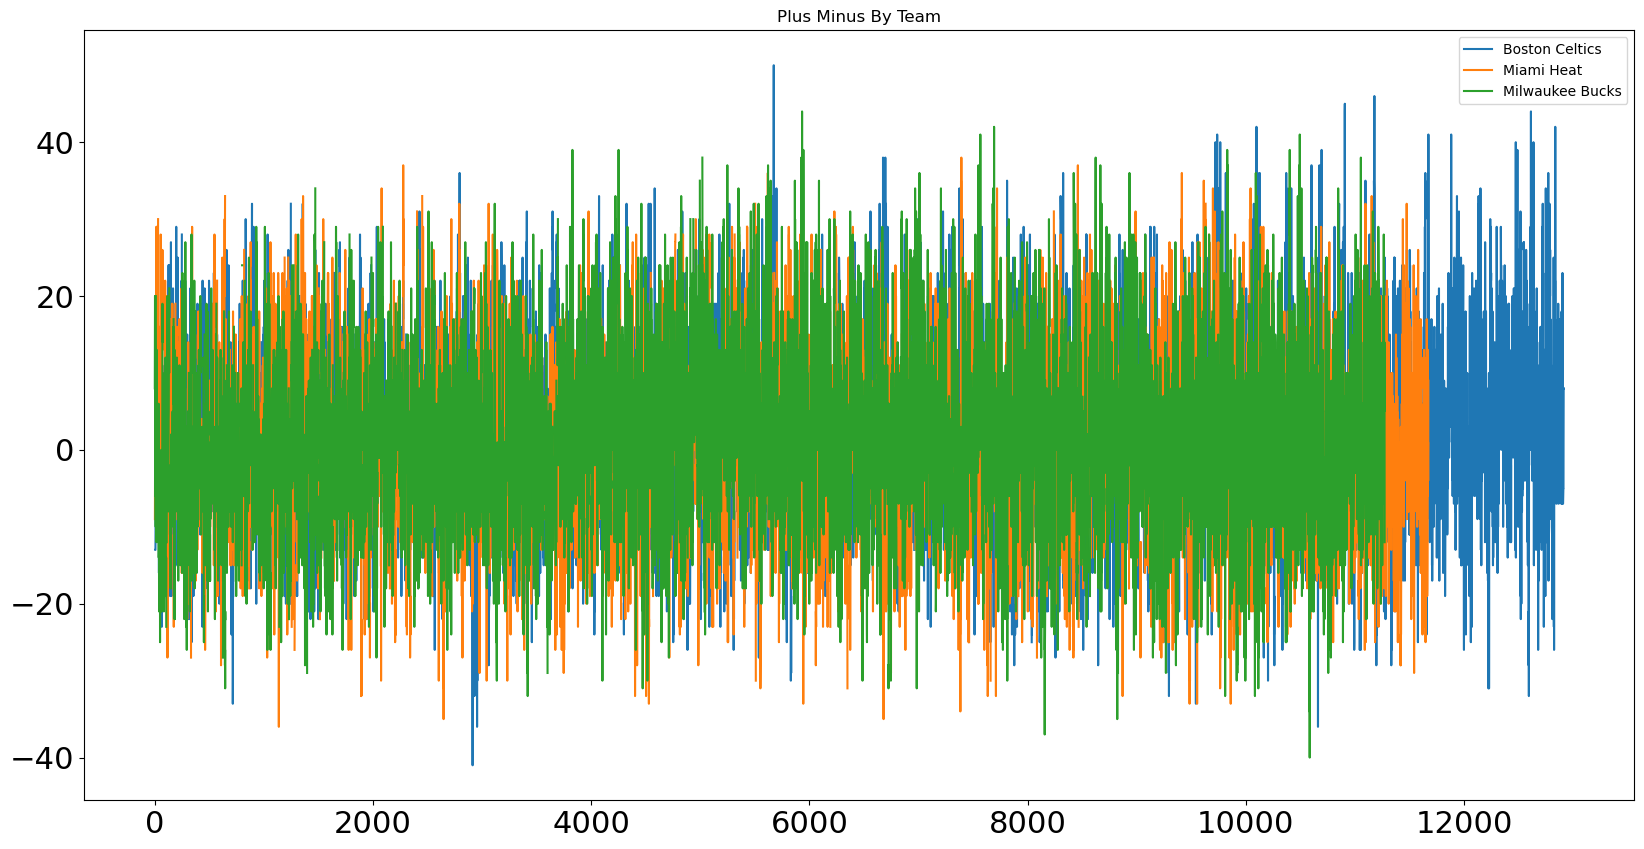

In [63]:
df[df['team_name'].isin({'Boston Celtics', 'Miami Heat', 'Milwaukee Bucks'})].groupby('team_name')['plusMinus'].plot(
    x=df.index.year, legend=True, figsize=(20, 10), use_index=False, title="Plus Minus By Team", 
    fontsize=fontsize, zorder=3)

- Now I want to compare LeBron vs Steph Curry plusMinus score over time as a visual

player_name
LeBron James     Axes(0.125,0.11;0.775x0.77)
Stephen Curry    Axes(0.125,0.11;0.775x0.77)
Name: plusMinus, dtype: object

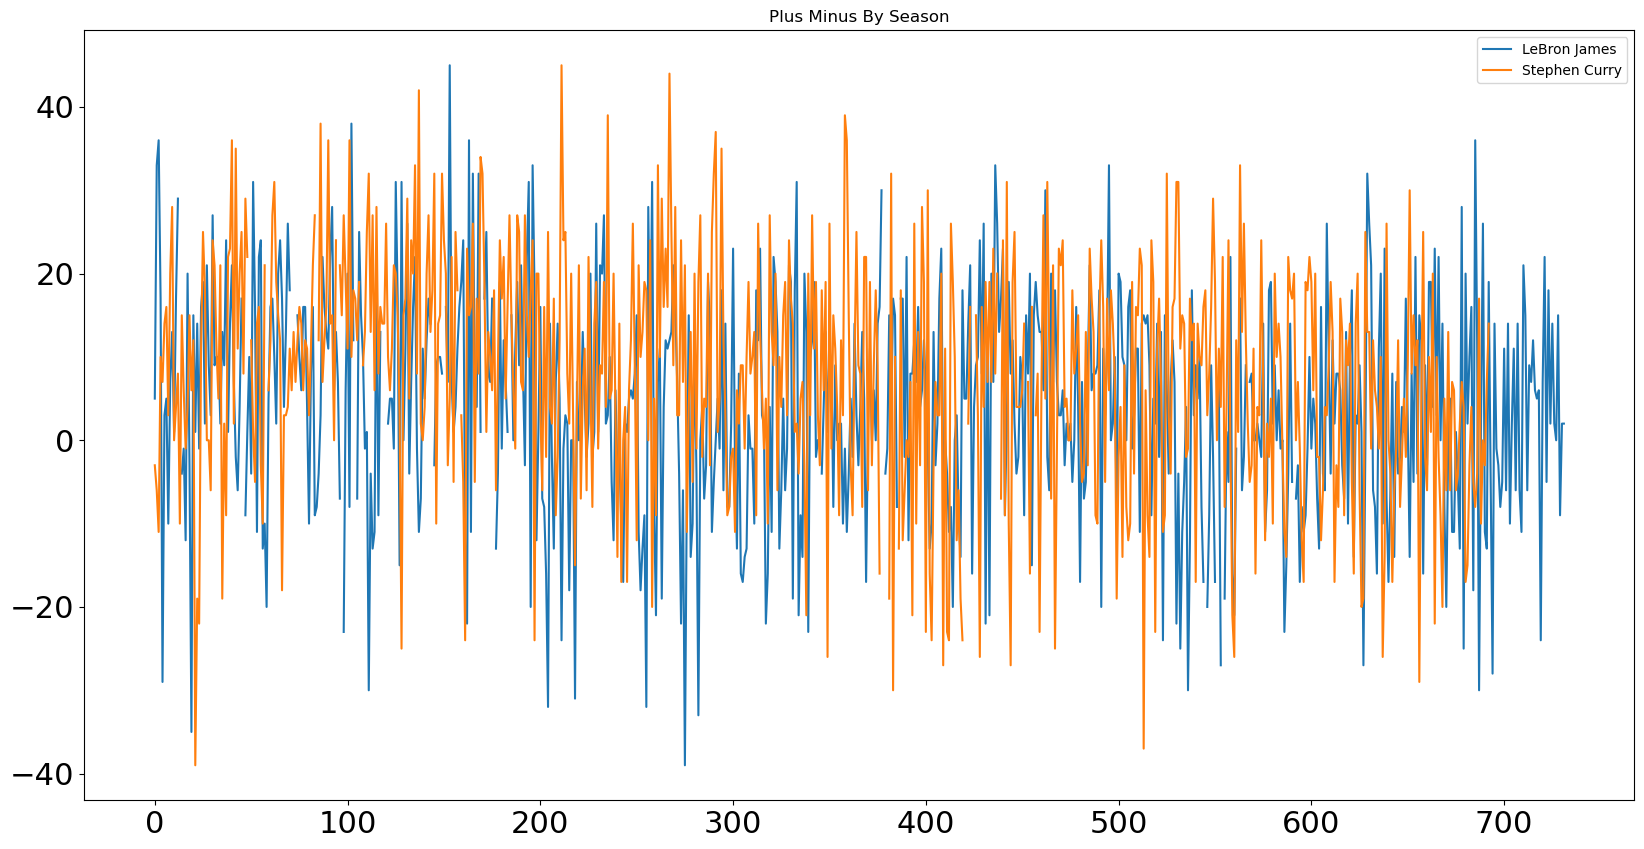

In [64]:
df[df['player_name'].isin({'LeBron James', 'Stephen Curry'})].groupby('player_name')['plusMinus'].plot(
    x=df.index.year, legend=True, figsize=(20, 10), use_index=False, title="Plus Minus By Season", 
    fontsize=fontsize, zorder=3)

- Lets try something similar with visualising season high for points scored for a less noisy plot

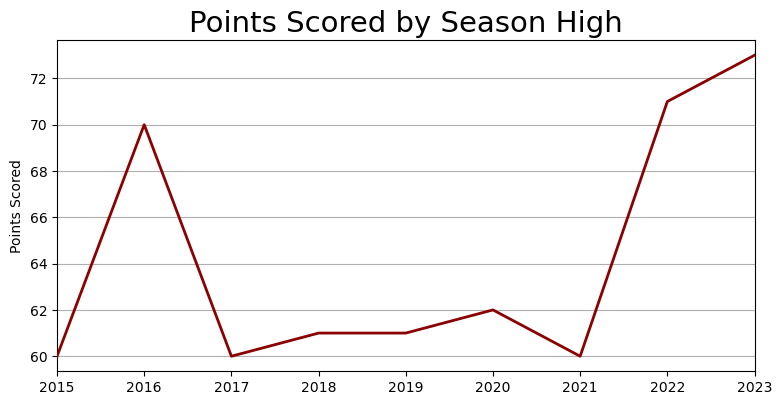

In [65]:
df_pts_per_yr = df.copy()
df_pts_per_yr.index = df_pts_per_yr.index.to_timestamp()

df_pts_per_yr = df_pts_per_yr['points'].resample("1Y").max()
ax = create_ts_plot(df_pts_per_yr, "Points Scored by Season High", "Points Scored", "darkred")

- Standout performances were on the up in 2023 with a season high 73 points (60-73pts was range for 9 years season high)
- Lets do the same for assists

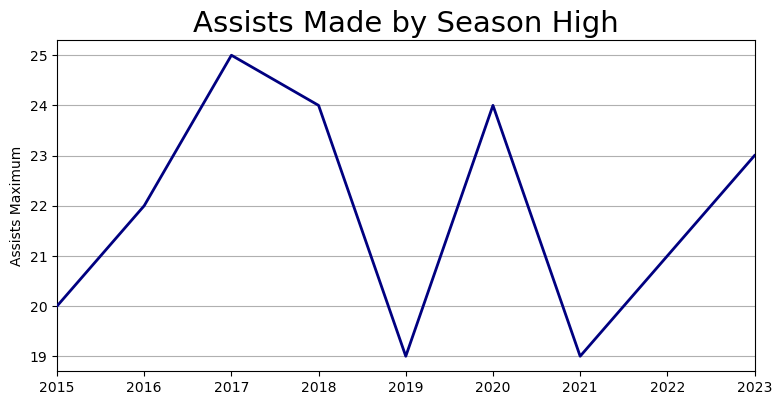

In [66]:
df_assts_per_yr = df.copy()
df_assts_per_yr.index = df_assts_per_yr.index.to_timestamp()

df_assts_per_yr = df_assts_per_yr['assists'].resample("1Y").max()
ax = create_ts_plot(df_assts_per_yr, "Assists Made by Season High", "Assists Maximum")

- 25 assists in a single game was the peak in the past 9 seasons
- The range for season high assists in a single game was [19, 25]
- Lets see the players that achieved these numbers

In [67]:
df[['player_name', 'assists']].sort_values(by='assists', ascending=False)[0:9]

player_name  assists
season                            
2017          Rajon Rondo     25.0
2018    Russell Westbrook     24.0
2020    Russell Westbrook     24.0
2023    Tyrese Haliburton     23.0
2016    Russell Westbrook     22.0
2017    Russell Westbrook     21.0
2020    Russell Westbrook     21.0
2020    Russell Westbrook     21.0
2022         James Harden     21.0

- Russell Westbrook remarkably appearing 6 times for this milestone

- Lets take another view at points scored, instead of viewing by season high lets make a box plot to see the avergae, median, outliers

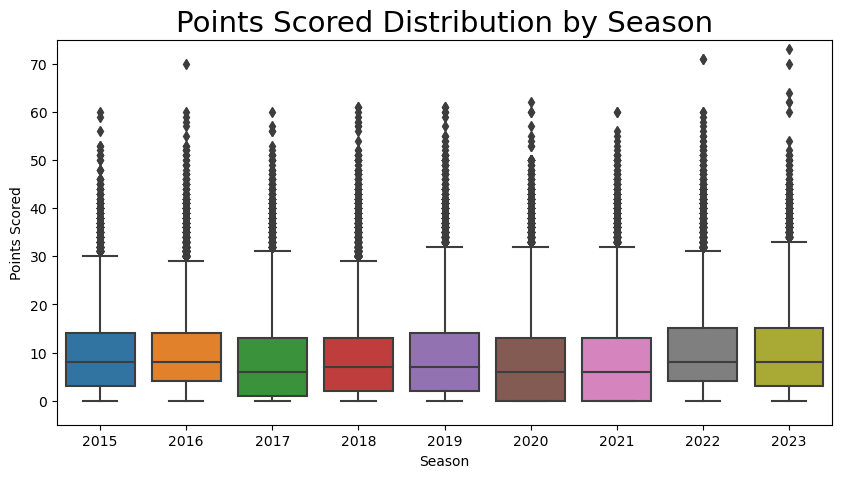

In [68]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x=df.index, y='points')
plt.title("Points Scored Distribution by Season", fontsize=fontsize-1)
plt.xlabel("Season")
plt.ylabel("Points Scored");
plt.ylim(-5, 75);

- Again this confirms 22/23' were strong seasons for scoring after lows in 2020/21' (`Note:` 2020/2021 was a shortened season for the covid bubble where lakers won the championship 2020 championship followed by the Bucks in 2021)
- Luka Doncic max for 2023 at 73 pts is the top scoring game over the past 9 years
- Giannis also has his franchise record for the Bucks as a notable outlier in the box plot above and summary table below
- Devin Bookers 70 point game in 2016 is a notable outlier from 2015 all the way up to 2022/2023 when single game scoring started to see some further outliers
- The median generally falling between 5-9 points.
- The bulk of player point totals per game falling between 5 and 15 points

In [69]:
df[['player_name', 'points']].sort_values(by='points', ascending=False)[0:6]# Highest single game scorers in the past 9 years

player_name  points
season                               
2023              Luka Doncic    73.0
2022         Donovan Mitchell    71.0
2022           Damian Lillard    71.0
2023              Joel Embiid    70.0
2016             Devin Booker    70.0
2023    Giannis Antetokounmpo    64.0

- Lets get the descriptive statitics for points and assists over 9 seasons
- We can see the inter quartile range, min, max, standard deviation and averages for the whole data set which again confirms some of the previous analysis

In [70]:
round(df[['points', 'assists']].describe(), 2)

points    assists
count  323325.00  323325.00
mean        9.09       2.00
std         8.41       2.44
min         0.00       0.00
25%         2.00       0.00
50%         7.00       1.00
75%        14.00       3.00
max        73.00      25.00

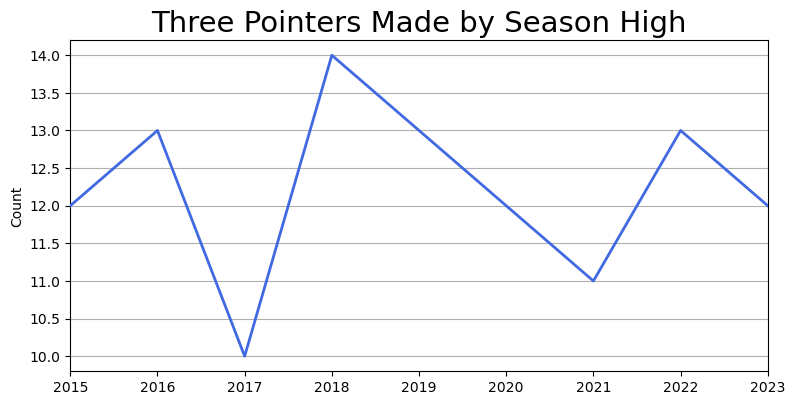

In [71]:
df_tpm_per_yr = df.copy()
df_tpm_per_yr.index = df_tpm_per_yr.index.to_timestamp()

df_tpm_per_yr = df_tpm_per_yr['tpm'].resample("1Y").max()
ax = create_ts_plot(df_tpm_per_yr, "Three Pointers Made by Season High", "Count", "royalblue")

- Lets take a look at the players that made the most 3-pointers in a single game

In [72]:
df[['player_name', 'tpm']].sort_values(by='tpm', ascending=False)[0:6]

player_name   tpm
season                      
2018     Klay Thompson  14.0
2016     Stephen Curry  13.0
2019       Zach LaVine  13.0
2022    Damian Lillard  13.0
2020    Damian Lillard  12.0
2015     Stephen Curry  12.0

- The same analysis for three pointers made in a single game (season high) throws up some interesting results
- Klay Thompsons 14 3pointers remains the peak for the last 9 seasons which means perhaps field goals and free throws made up a lot of the high scoring games mentioned earlier
- The game specific stats are available from another end-point which may be worth adding as a next step to this analysis

- Next, Create function to calculate productivity matrix to generate heat maps and charts for top players in the NBA over the last 9 seasons
- This matrix needs to normalise all numeric features to the range [0, 1]
- I am adding some filters related to minutes played, fouls and turnovers to rule out some players that may not have contributed well over a longer time period (rookies, players injured for long duration etc.) with notable drawbacks to their individual performance.

In [73]:
cols_pos = ['assists', 'blocks', 'steals', 'fgm', 'fgp', 'ftm', 'ftp', 'totReb', 'tpm', 'tpp', 'points', 'min', 'plusMinus']
cols_neg = ['pFouls', 'turnovers', 'min']


def calc_productivity_matrix(df_temp, cols, min_thresh = 0.75):
    # group by player and get mean / averages for 2015-2023 (9 years)
    df_prod = df_temp.groupby("player_name")[cols].mean()

    # min-max normalisation of data frame
    df_norm_prod = (df_prod - df_prod.min()) / (df_prod.max() - df_prod.min())

    # drop records with NA values
    df_prod_heatmap = round(df_norm_prod.dropna(), 2)
    
    # filter out players with less playing experience
    if 'min' in df_prod_heatmap.columns:
        df_prod_heatmap = df_prod_heatmap[df_prod_heatmap['min'] > min_thresh]

    # calculate row sum as a sort of productivity indicator (can be based on positive or negative contributions)
    df_prod_heatmap['player_sum'] = df_prod_heatmap.sum(axis=1)

    # sort and find top 15 players
    df_prod_heatmap = df_prod_heatmap.sort_values('player_sum', ascending=False)[0:15]
    return df_prod_heatmap[cols]

- View matrix of players making a strongly positive impact for their teams

In [74]:
positive_prod = calc_productivity_matrix(df, cols_pos)
positive_prod

assists  blocks  steals   fgm   fgp   ftm   ftp  \
player_name                                                              
James Harden              0.95    0.14    0.39  0.80  0.43  0.96  0.84   
Luka Doncic               0.87    0.10    0.29  0.96  0.46  0.76  0.72   
Stephen Curry             0.64    0.06    0.36  0.91  0.47  0.58  0.83   
Kevin Durant              0.56    0.28    0.21  0.95  0.53  0.75  0.86   
Joel Embiid               0.37    0.36    0.21  0.87  0.49  1.00  0.80   
LeBron James              0.85    0.16    0.32  0.99  0.52  0.57  0.69   
Giannis Antetokounmpo     0.58    0.29    0.30  0.96  0.54  0.80  0.67   
Damian Lillard            0.73    0.07    0.24  0.83  0.43  0.80  0.87   
Trae Young                1.00    0.03    0.26  0.80  0.42  0.82  0.82   
Anthony Davis             0.29    0.48    0.32  0.91  0.51  0.74  0.75   
Kawhi Leonard             0.40    0.14    0.42  0.84  0.49  0.64  0.80   
Nikola Jokic              0.73    0.16    0.30  0.80  0.55  0.47  0.71   
Paul George               0.44    0.09    0.42  0.78  0.43  0.58  0.76   
Kyrie Irving              0.60    0.11    0.31  0.90  0.47  0.46  0.79   
Jayson Tatum              0.39    0.15    0.28  0.79  0.45  0.57  0.74   

                       totReb   tpm   tpp  points   min  plusMinus  
player_name                                                         
James Harden             0.52  0.71  0.35    0.95  0.94       0.59  
Luka Doncic              0.69  0.64  0.33    1.00  0.97       0.54  
Stephen Curry            0.42  1.00  0.41    0.97  0.89       0.66  
Kevin Durant             0.57  0.47  0.40    0.97  0.96       0.65  
Joel Embiid              0.87  0.24  0.30    0.94  0.91       0.61  
LeBron James             0.65  0.42  0.33    0.93  0.93       0.58  
Giannis Antetokounmpo    0.87  0.17  0.24    0.93  0.88       0.59  
Damian Lillard           0.35  0.72  0.35    0.94  0.93       0.55  
Trae Young               0.28  0.56  0.33    0.89  0.93       0.49  
Anthony Davis            0.86  0.14  0.22    0.88  0.91       0.53  
Kawhi Leonard            0.53  0.42  0.38    0.85  0.89       0.63  
Nikola Jokic             0.86  0.23  0.31    0.74  0.91       0.60  
Paul George              0.53  0.65  0.38    0.83  0.89       0.58  
Kyrie Irving             0.34  0.57  0.38    0.86  0.95       0.58  
Jayson Tatum             0.58  0.53  0.36    0.81  0.97       0.62

- View matrix of players that have a bias/weight against the positive contributions they make (fouls and turnovers can be costly especially on a regular basis)

In [75]:
negative_prod = calc_productivity_matrix(df, cols_neg)
negative_prod

pFouls  turnovers   min
player_name                                   
James Harden             0.43       1.00  0.94
Luka Doncic              0.37       0.92  0.97
Joel Embiid              0.51       0.78  0.91
Trae Young               0.30       0.97  0.93
Cade Cunningham          0.48       0.82  0.87
Giannis Antetokounmpo    0.51       0.76  0.88
LaMelo Ball              0.50       0.75  0.88
Devin Booker             0.48       0.69  0.94
Julius Randle            0.51       0.65  0.92
LeBron James             0.29       0.84  0.93
Nikola Jokic             0.46       0.67  0.91
Karl-Anthony Towns       0.56       0.62  0.86
Paul George              0.46       0.67  0.89
Kevin Durant             0.33       0.72  0.96
Domantas Sabonis         0.51       0.58  0.92

- View heatmap with annotations of positive player productivity 
- Dark squares map to low scores and pale squares map to higher ranking annotation or score for the given player/feature

<Axes: ylabel='player_name'>

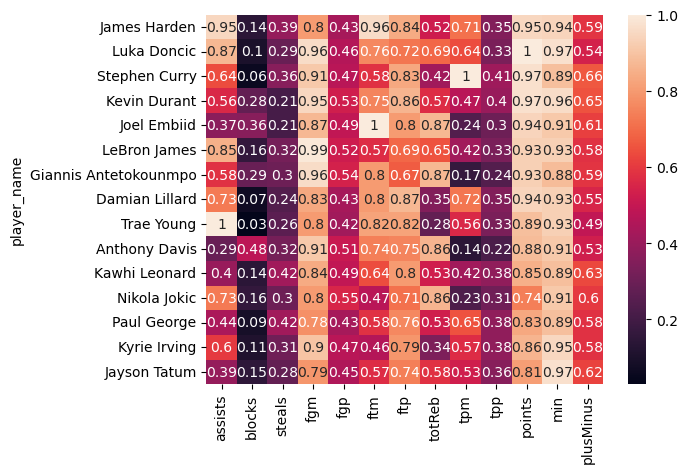

In [76]:
sns.heatmap(positive_prod, annot=True)

- View heatmap with annotations of negative player productivity 

<Axes: ylabel='player_name'>

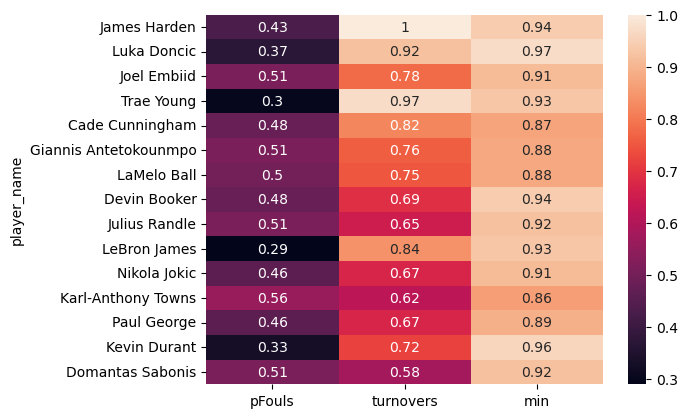

In [77]:
sns.heatmap(negative_prod, annot=True)

- We can see James Harden has a very high turnover rate along with Luka Doncic and Trae Young
- Luka, Joel and Giannis have a high combined rate of personal fouls commited coupled with turnovers
- Karl-Anthony Towns ranks highly for personal fouls committed
- Next, lets use the players appearing high up in the list for turnovers/personal fouls as another layer of selection criteria that we can use to exclude players from the top team players in the NBA over the past 9 years

In [78]:
players_to_exclude = positive_prod.index.intersection(negative_prod.index)
players_to_exclude

Index(['James Harden', 'Luka Doncic', 'Kevin Durant', 'Joel Embiid',
       'LeBron James', 'Giannis Antetokounmpo', 'Trae Young', 'Nikola Jokic',
       'Paul George'],
      dtype='object', name='player_name')

- Lets view the heat map table after excluding players with some drawbacks to their general play/performance (fouls & turnovers, not enough playing time etc.)
- `James Harden`, `Luka Doncic`, `Kevin Durant`, `Joel Embiid`, `LeBron James`, `Giannis Antetokounmpo`, `Trae Young`, `Nikola Jokic`, and `Paul George` all lose out here and are all household names in the NBA

In [79]:
df_team_pos_players = positive_prod[~positive_prod.index.isin(players_to_exclude)]
df_team_pos_players

assists  blocks  steals   fgm   fgp   ftm   ftp  totReb   tpm  \
player_name                                                                     
Stephen Curry      0.64    0.06    0.36  0.91  0.47  0.58  0.83    0.42  1.00   
Damian Lillard     0.73    0.07    0.24  0.83  0.43  0.80  0.87    0.35  0.72   
Anthony Davis      0.29    0.48    0.32  0.91  0.51  0.74  0.75    0.86  0.14   
Kawhi Leonard      0.40    0.14    0.42  0.84  0.49  0.64  0.80    0.53  0.42   
Kyrie Irving       0.60    0.11    0.31  0.90  0.47  0.46  0.79    0.34  0.57   
Jayson Tatum       0.39    0.15    0.28  0.79  0.45  0.57  0.74    0.58  0.53   

                 tpp  points   min  plusMinus  
player_name                                    
Stephen Curry   0.41    0.97  0.89       0.66  
Damian Lillard  0.35    0.94  0.93       0.55  
Anthony Davis   0.22    0.88  0.91       0.53  
Kawhi Leonard   0.38    0.85  0.89       0.63  
Kyrie Irving    0.38    0.86  0.95       0.58  
Jayson Tatum    0.36    0.81  0.97       0.62

- This is the final elite group, I would like to display further information about these players

In [80]:
df_elite_players = df[df['player_name'].isin(df_team_pos_players.index)][['player_name', 'team_name', 'active', 'years_pro', 'affiliation', 'college', 'country', 'age', 'rookie_year']].reset_index(drop=True).drop_duplicates().sort_values('player_name')
df_elite_players['years_pro'] = df_elite_players['years_pro'].astype('int')
df_elite_players['age'] = df_elite_players['age'].astype('int')
df_elite_players['rookie_year'] = df_elite_players['rookie_year'].astype('int')
df_elite_players

player_name               team_name active  years_pro  \
21     Anthony Davis    New Orleans Pelicans   True          9   
2111   Anthony Davis      Los Angeles Lakers   True          9   
155   Damian Lillard  Portland Trail Blazers   True          9   
3741  Damian Lillard         Milwaukee Bucks   True          9   
1124    Jayson Tatum          Boston Celtics   True          4   
355    Kawhi Leonard       San Antonio Spurs   True         10   
1472   Kawhi Leonard         Toronto Raptors   True         10   
2208   Kawhi Leonard             LA Clippers   True         10   
0       Kyrie Irving     Cleveland Cavaliers   True         10   
1150    Kyrie Irving          Boston Celtics   True         10   
1936    Kyrie Irving           Brooklyn Nets   True         10   
3042    Kyrie Irving        Dallas Mavericks   True         10   
248    Stephen Curry   Golden State Warriors   True         12   

              affiliation          college    country  age  rookie_year  
21           Kentucky/USA         Kentucky        USA   31         2012  
2111         Kentucky/USA         Kentucky        USA   31         2012  
155       Weber State/USA      Weber State        USA   33         2012  
3741      Weber State/USA      Weber State        USA   33         2012  
1124             Duke/USA             Duke        USA   26         2017  
355   San Diego State/USA  San Diego State        USA   32         2011  
1472  San Diego State/USA  San Diego State        USA   32         2011  
2208  San Diego State/USA  San Diego State        USA   32         2011  
0          Duke/Australia             Duke  Australia   31         2011  
1150       Duke/Australia             Duke  Australia   31         2011  
1936       Duke/Australia             Duke  Australia   31         2011  
3042       Duke/Australia             Duke  Australia   31         2011  
248          Davidson/USA         Davidson        USA   36         2009

- We can see all players are active, the teams they have represented (most recent record is where index value is highest), country and college info, age and when they turned professional.
- `Stephen Curry` is the oldest and most experienced player in this group followed by Damian Lillard.
- We can see `Jayson Tatum & Stephen Curry` are loyal players as they have stayed with the team the drafted them to this point.
- Kyrie Irving is the only non-americans in the list.
- This is a bit messy for players that have represented more than one team in the 9 year timeframe so lets get the most recent team information for each of these players only (to reduce the noise / record count).

In [81]:
df_elite_players.sort_index(axis=0, ascending=False).groupby('player_name').first()

team_name active  years_pro          affiliation  \
player_name                                                                    
Anthony Davis      Los Angeles Lakers   True          9         Kentucky/USA   
Damian Lillard        Milwaukee Bucks   True          9      Weber State/USA   
Jayson Tatum           Boston Celtics   True          4             Duke/USA   
Kawhi Leonard             LA Clippers   True         10  San Diego State/USA   
Kyrie Irving         Dallas Mavericks   True         10       Duke/Australia   
Stephen Curry   Golden State Warriors   True         12         Davidson/USA   

                        college    country  age  rookie_year  
player_name                                                   
Anthony Davis          Kentucky        USA   31         2012  
Damian Lillard      Weber State        USA   33         2012  
Jayson Tatum               Duke        USA   26         2017  
Kawhi Leonard   San Diego State        USA   32         2011  
Kyrie Irving               Duke  Australia   31         2011  
Stephen Curry          Davidson        USA   36         2009

- Now we see one record for each player and only for the team they currently represent
- `Jayson Tatum` has time on his side to improve his rankings as all the other players are professionals for 9 years or longer

- Lets view the productivity table as a heatmap to help identify where each player excels
- The darker the cell background, the better or the higher the player ranking for the given feature used for analysis

In [82]:
df_team_pos_players.style.background_gradient(cmap='Blues')

- We can already see a pattern emerging for the order of the list, tpp (three-point percentage), points and plusMinus are basically going from a paler square or light blue to navy as we go to the top of the list with Stephen Curry.
- Lets try this in a Seaborn line plot instead to see if there are any other obvious patterns
- Heat Maps (Numbers/Annotations/Cell colours etc.) sometimes dont show the obvious gap in some areas

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

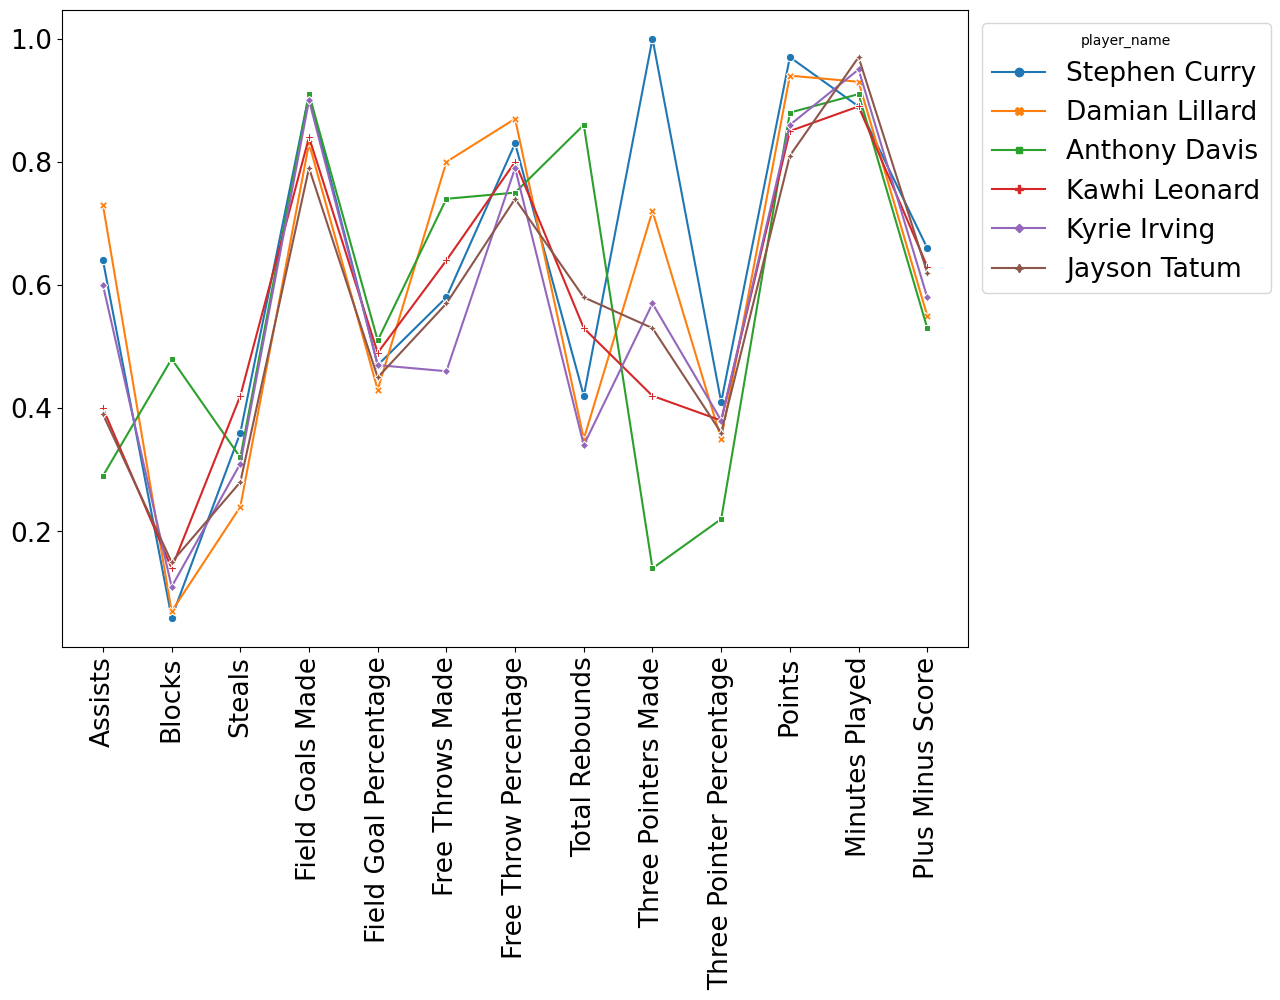

In [83]:
a4_dims= [11.7, 8.27]
fig, ax = plt.subplots(figsize=a4_dims)
df_team_pos_players = df_team_pos_players.rename(columns={'assists': 'Assists',
                                                          'blocks': 'Blocks',
                                                          'steals': 'Steals',
                                                          'fgm' : 'Field Goals Made',
                                                          'fgp' : 'Field Goal Percentage',
                                                          'ftm' : 'Free Throws Made',
                                                          'ftp' : 'Free Throw Percentage',
                                                          'totReb' : 'Total Rebounds',
                                                          'tpm' : 'Three Pointers Made',
                                                          'tpp' : 'Three Pointer Percentage',
                                                          'points': 'Points',
                                                          'min': 'Minutes Played',
                                                          'plusMinus': 'Plus Minus Score'})
ax = sns.lineplot(ax=ax, data=df_team_pos_players.T, markers=True, dashes=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1), fontsize=19)
plt.xticks(rotation = "vertical", fontsize=19)
plt.yticks(fontsize=19)

- We can now see `Steph Curry` is in a league of his own for three point shooting (Blue line peak right of middle)
- While `Damian Lillard` is tops for Assists and Free Throws at the elite level (Orange Line), which also means he is very good a drawing fouls from the opposition (something not obvious in stats except for plus minus score or something more generic)
- `Steph Curry` peaks again for Points, a natural scorer
- `Steph Curry` has a low for blocks, while `Anthony Davis` is particularly weak on Three Pointers but very strong in rebounding and blocks.

- Anthony Davis is a ntoable shot blocker here (green line).
    - This is interesting because, through previous analysis, the latest number 1 draft pick has a similar trajectory to `Anthony Davis` because they are both extremely good shot blockers and rebounders, However, `Victor Wembanyama` of `France` has the ability to shoot well from three point range and possibly peform even better in relation to assists and blocks.
- I want to view this theory by displaying AD against Victor in this format (Experience Vs Youth).

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0')])

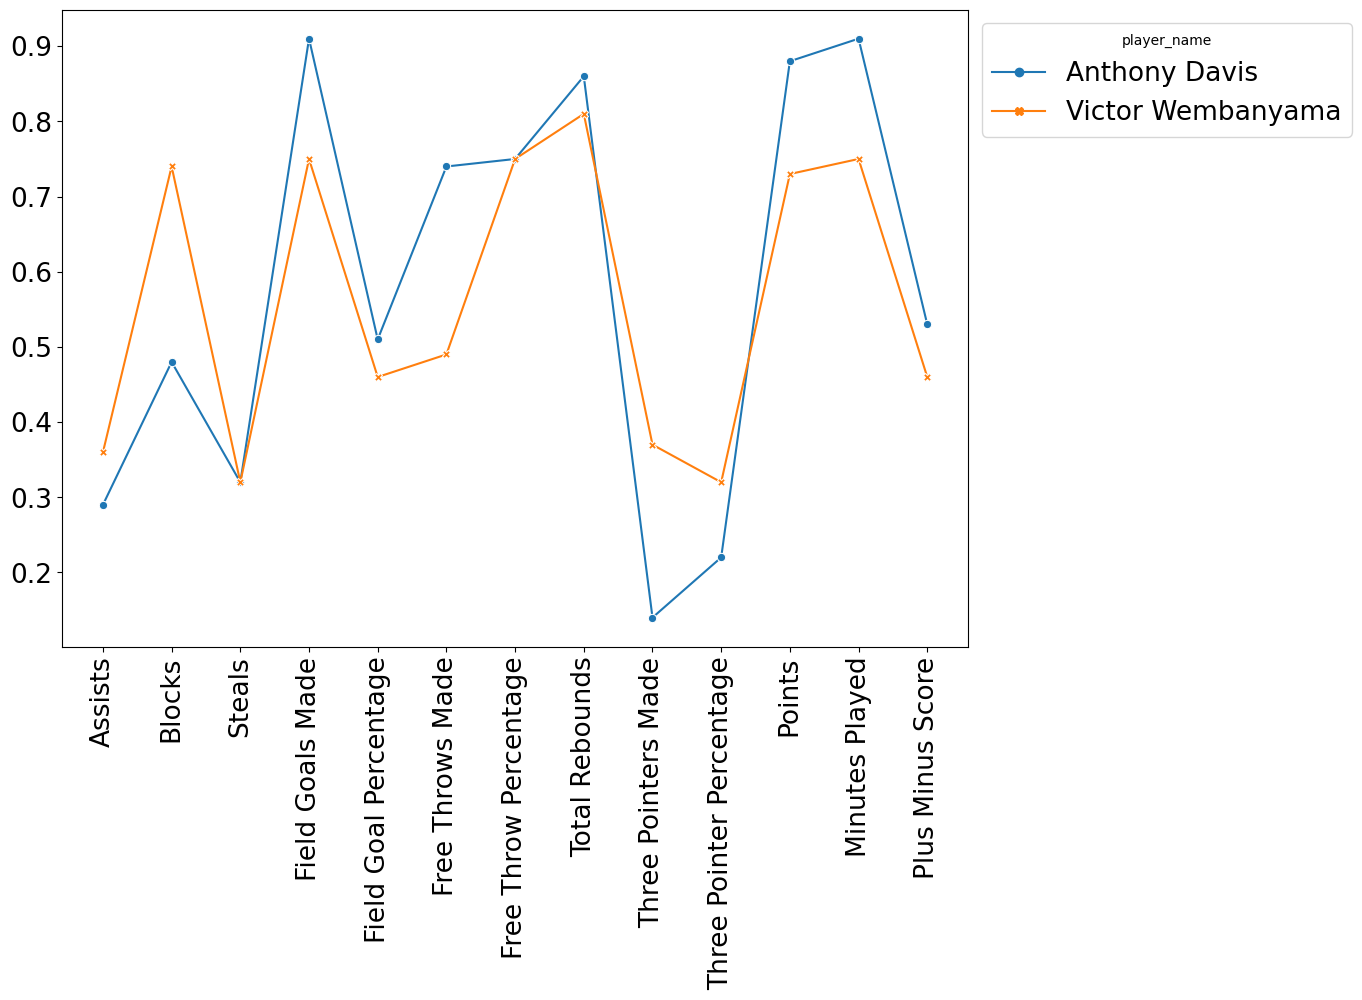

In [84]:
df_matrix_70 = calc_productivity_matrix(df, cols_pos, min_thresh=0.7)# lower minustes played threshold to pull in less experienced pros and rookies that are performing well
df_victor_ad = df_matrix_70[df_matrix_70.index.isin(['Victor Wembanyama', 'Anthony Davis'])]
a4_dims= [11.7, 8.27]
fig, ax = plt.subplots(figsize=a4_dims)
df_victor_ad = df_victor_ad.rename(columns={'assists': 'Assists',
                                                          'blocks': 'Blocks',
                                                          'steals': 'Steals',
                                                          'fgm' : 'Field Goals Made',
                                                          'fgp' : 'Field Goal Percentage',
                                                          'ftm' : 'Free Throws Made',
                                                          'ftp' : 'Free Throw Percentage',
                                                          'totReb' : 'Total Rebounds',
                                                          'tpm' : 'Three Pointers Made',
                                                          'tpp' : 'Three Pointer Percentage',
                                                          'points': 'Points',
                                                          'min': 'Minutes Played',
                                                          'plusMinus': 'Plus Minus Score'})
ax = sns.lineplot(ax=ax, data=df_victor_ad.T, markers=True, dashes=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1), fontsize=19)
plt.xticks(rotation = "vertical", fontsize=19)
plt.yticks(fontsize=19)



- Overall, we can see ADs experience shines through but very promising stats so far from the latest #1 draft pick

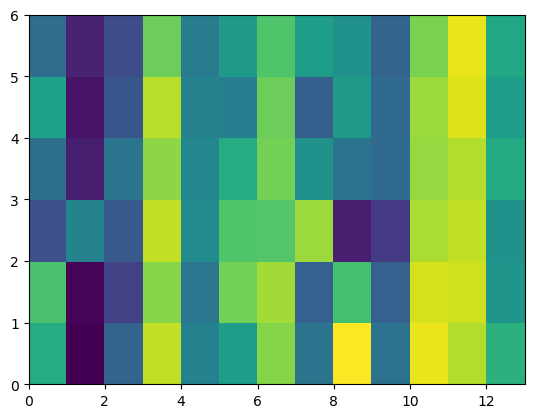

In [85]:
plt.pcolor(df_team_pos_players)

- We can see how yellow matches up with the pale colours below and navy above matches closely to black or low ranking squares below
- The annotations and index labelling really is helpful for decoding and making sense of this visualisation though so it is important to try different libraries/packages when possible like plotly, mathplotlib, Seaborn, Bokeh etc.
- Seaborn on this occasion is a better visual with more information packed in automatically, I like because it is easy to use.

<Axes: ylabel='player_name'>

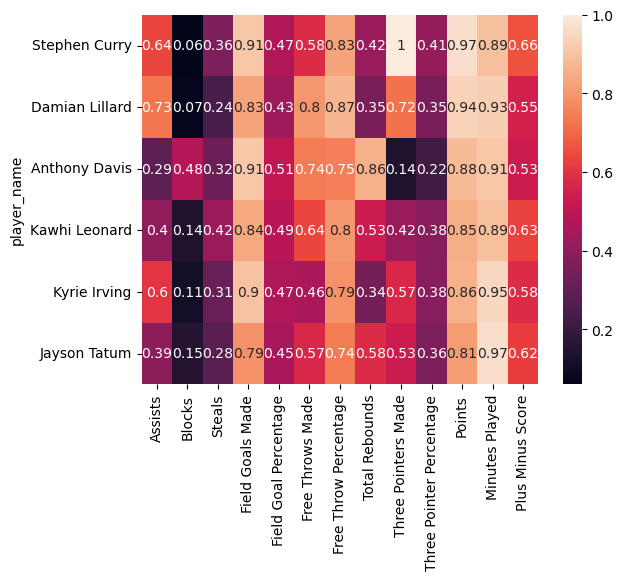

In [86]:
sns.heatmap(df_team_pos_players, annot=True)

- After messing around with different visuals of this final elite group of players, I think an interactive stacked bar chart might be the best option for this data overall.
- Lets view each players bar chart first after we set a color for each statistic type

In [87]:
stat_cols = ['Assists', 'Blocks', 'Steals', 'Field Goals Made', 'Field Goal Percentage', 'Free Throws Made', 
             'Free Throw Percentage', 'Total Rebounds', 'Three Pointers Made', 'Three Pointer Percentage', 'Points',
             'Minutes Played', 'Plus Minus Score']
colours = ["limegreen", "red", "navy", "lightblue", "darkorange", "pink", "lightgreen", "orange", "darkgreen",
           "purple", "blue", "darkred", "yellow"]

stats_colours = dict(zip(stat_cols, colours))
stats_colours

{'Assists': 'limegreen',
 'Blocks': 'red',
 'Steals': 'navy',
 'Field Goals Made': 'lightblue',
 'Field Goal Percentage': 'darkorange',
 'Free Throws Made': 'pink',
 'Free Throw Percentage': 'lightgreen',
 'Total Rebounds': 'orange',
 'Three Pointers Made': 'darkgreen',
 'Three Pointer Percentage': 'purple',
 'Points': 'blue',
 'Minutes Played': 'darkred',
 'Plus Minus Score': 'yellow'}

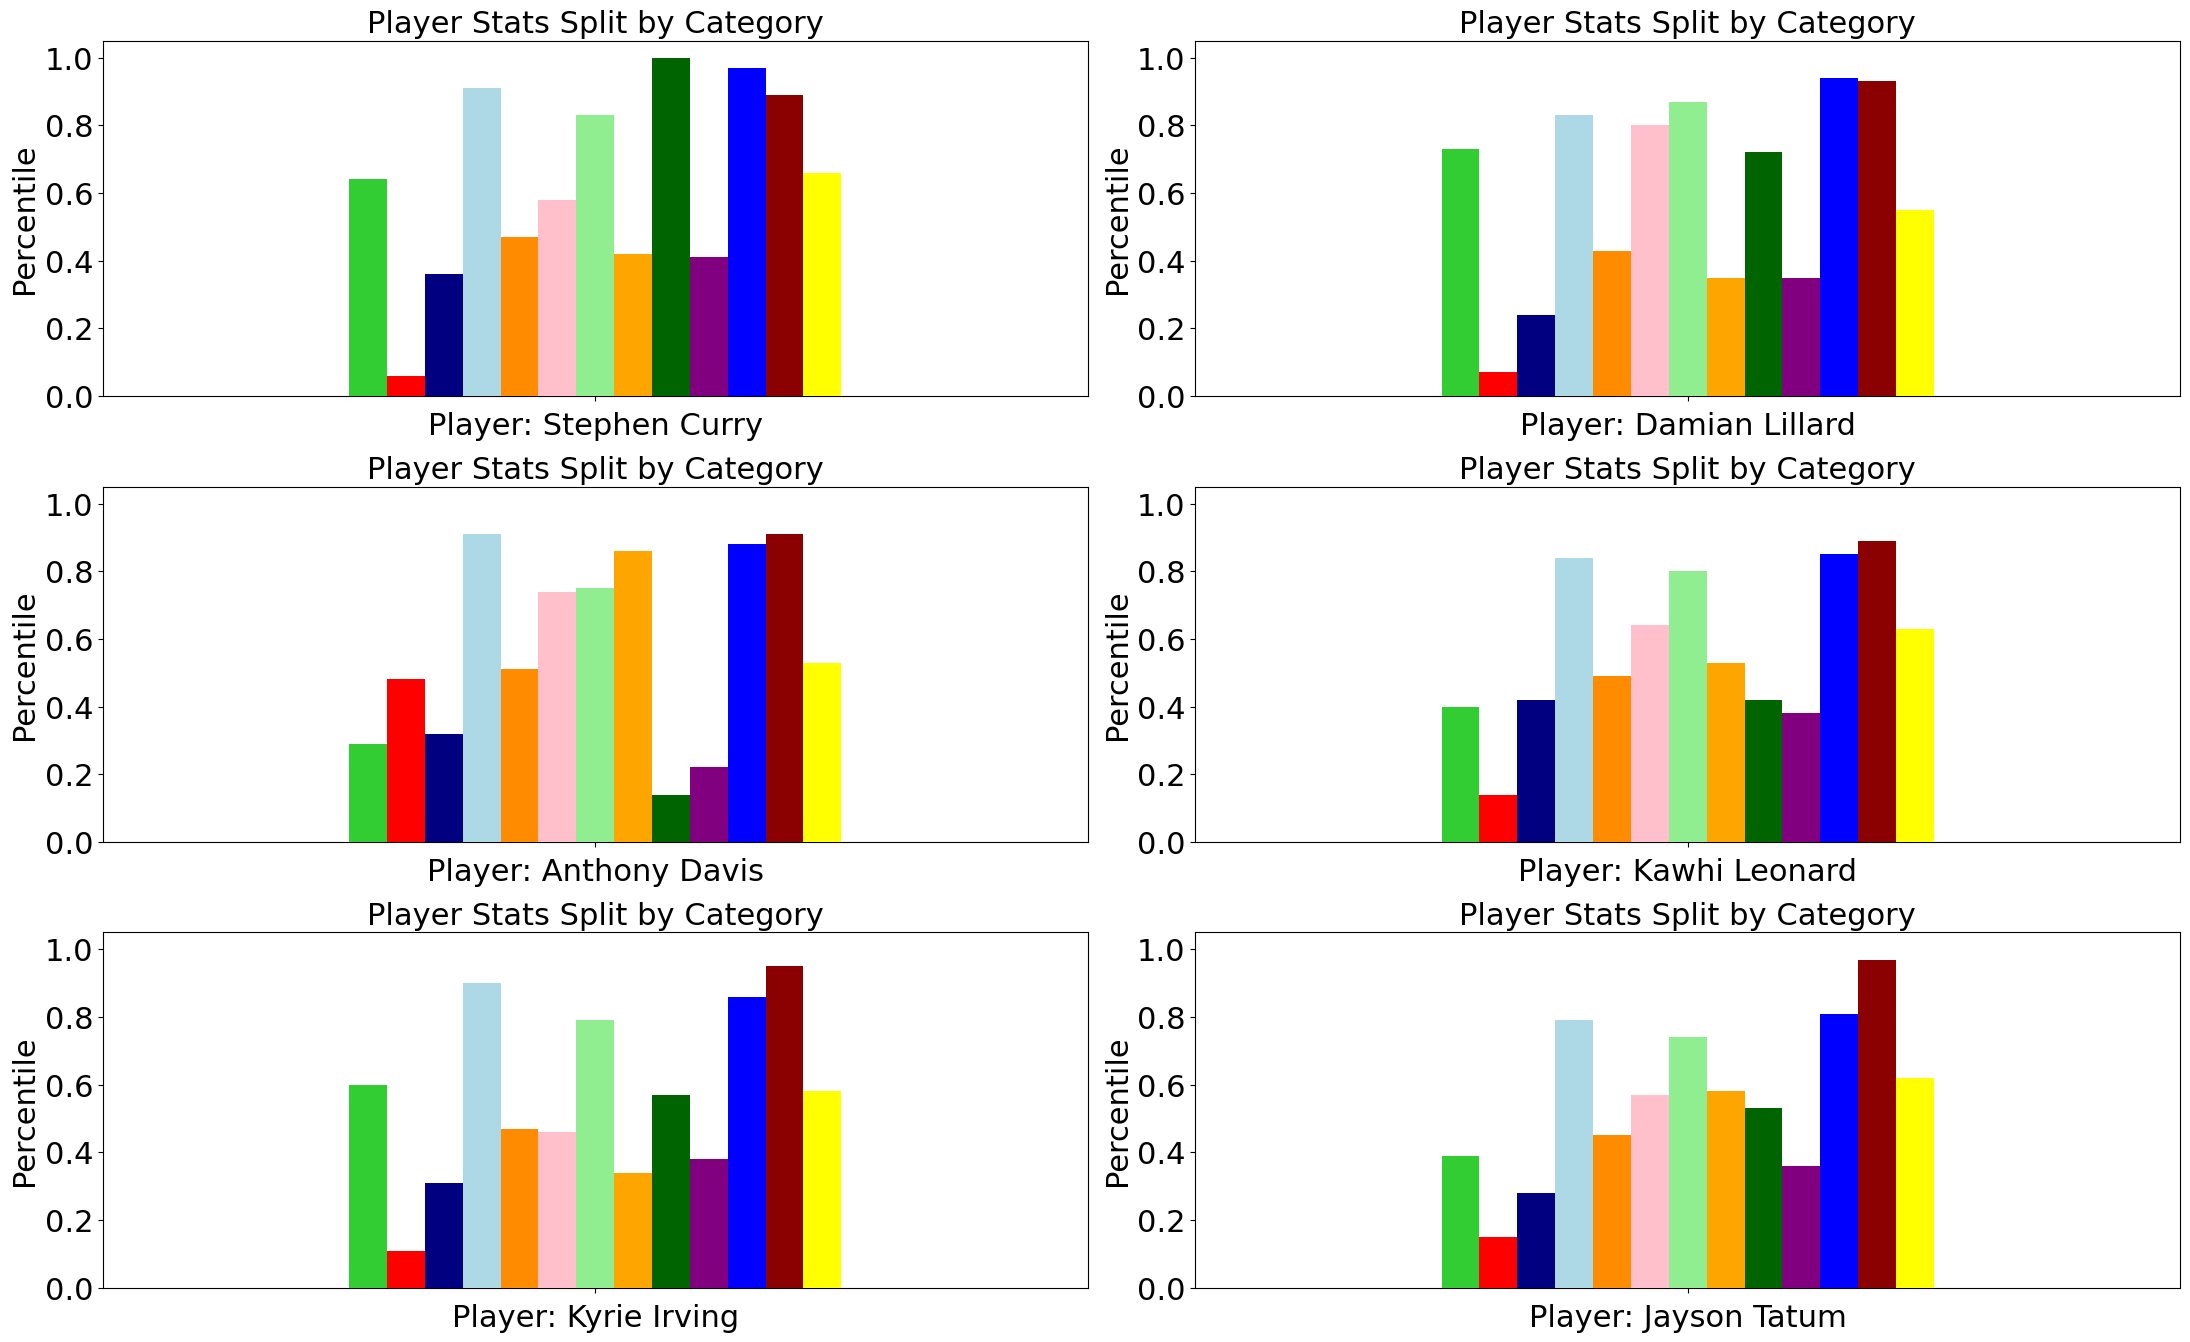

In [88]:
fig = plt.figure(figsize=(22, 22))
for i, player in enumerate(df_team_pos_players.index):
    # create the sub plot
    axc = fig.add_subplot(5, 2, i+1)
    ax = df_team_pos_players[df_team_pos_players.index == player].plot.bar(ax=axc, 
                                                                           legend=False,
                                                                           y=stat_cols, 
                                                                           color=stats_colours, 
                                                                           fontsize=fontsize, 
                                                                           zorder=3)
    # configure axis ticks / labels
    xticklabels = ""
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(xticklabels))
    ax.set_title("Player Stats Split by Category", fontsize=fontsize)
    ax.set_xlabel("Player: %s" % player, fontsize=fontsize)
    ax.set_ylabel("Percentile", fontsize=fontsize)
    ax.set_ylim([.0, 1.05])
    ax.yaxis.grid=True;
fig.tight_layout()                                               

- Lets merge this visualisation into one interactive plot

In [89]:
result_bc = df_team_pos_players.plot(backend='plotly', kind='bar', labels=dict(variable='Stat Category', 
                                                                               value='Normalised Proportion of Productivity'))
result_bc.layout.xaxis.title.text = 'Player Name'
result_bc

- We can now see that Stephen Curry and Damian Lillard are particularly strong on three point shooting, Steph & Anthony Davis (AD) for Field Goals Made, AD for Rebounding, Damian Lillard for assists, and AD for Blocks.
- This `visual helps decode where the top players are particularly strong and possible areas of improvement`.
- This is strong evidence for players that are within or atleast close to the top 10 performing players in the NBA over the last 9 seasons
- Notably the minutes played, points, plusMinus score, steals, and FTP (free throw percentage) area of bars is similar for all players in this group.
- `Three pointers, assists, blocks and rebounds` are key areas of differentiation at the top end of the NBA judging by this visual.

### 3. Discussion

- The data used is spread across `2 different endpoints` with a limitation that only data from the years `2015-2023` is available. The volume of data involved is still quite substantial at `more than 309,000 records`.
- The data used is from `540` API requests and there was a lot of time trying to pre-process and merge this data into something useful via player ID and other features.
- There was a lot of `nested JSON objects` that had features I needed to extract, parse and format into something useful for the analysis here.
- There were other difficulties such as `missing Country and College` information etc. for rookies or lesser known players such as Victor Wembanyama so the API covers a lot and is being updated all the time but is not perfect.
- Data verification tasks included searching online for the single game records for points, assists, and three pointers made in the past 9 years. In addition, I completed some verification of the data actually loaded into the notebook along with some other spot checks (ongoing task for data of this nature as it is being updated all the time).
- The key insights were the `top players by statistic` (total and averges) for certain stats in the NBA along with the final stacked bar chart and heatmaps which help identify some of the `most productive and high performing players` over the last `9 years`.

- I was able to track down a group of players that represent an `elite group that best contributed to their respective teams over a 9 year period` (all stars with 2 players (Damian Lillard & Jayson Tatum) that have yet to win a championship ring but have featured in several playoff series and all star weekends etc.).

- I think the next step would be to pull `game data and statistics` by game ID. We could then use this in combination with player ID and team ID (as some players have moved / were traded to several different teams over the years) to merge this data into the main DataFrame to get an idea of the win rate associated with the players here and the split of `regular season statistics vs playoff games`. 

- I would like to also see how player performance varies from one franchise to another, such as `LeBron at Miami vs LeBron at the Lakers`. 

- Right now it is hard to see which data is regular or post season and what players do not perform well in the playoffs vs regular season games. This would be another key insight to try visualise, perhaps more important than the average 'plusMinus' score or the method I have used to find the most impactful NBA players over the last 9 seasons.

- I think a view of the final stacked bar chart per season would allow to see what players are trending up and what players are trending down in their performance levels. This may show that I wrongly excluded players like: `James Harden`, `Luka Doncic`, `Kevin Durant`, `Joel Embiid`, `LeBron James`, `Giannis Antetokounmpo`, `Trae Young`, `Nikola Jokic`, and `Paul George` from the final elite players group for the past 9 years. However, from the players excluded, `Durant, LeBron, Giannis and Nikola` are the players to be part of a winning championship team. To that end, `Gianis` and `Nikola Jokic` are under 30, while `LeBron` and `Kevin Durant` are 39 & 35 years of age respectively. 